In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder

%matplotlib inline

In [23]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test["is_promoted"] = np.nan
print train.shape, test.shape

(54808, 14) (23490, 14)


# Simple LGBM Model

In [24]:
train_id = train[["employee_id"]]
test_id = test[["employee_id"]]
target = train.is_promoted

train = train.drop(["employee_id","is_promoted"], axis=1)
test = test.drop(["employee_id","is_promoted"], axis=1)

data = pd.concat([train, test], axis=0).reset_index(drop=True)
data["previous_year_rating"] = data["previous_year_rating"].fillna(0)
data["education"] = data["education"].fillna("NoData")

# Feature Engineering Start
data["department_size"] = data["department"].map(data.groupby("department").size())

data["department_average_training_scores"] = data["department"].map(data.groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_average_training_score_in_department"] = data.apply(lambda x: ((x["department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["department_average_training_scores"]), axis=1)
data = data.drop(["department_average_training_scores"], axis=1)

data["kpi_positive_department_average_training_scores"] = data["department"].map(data.loc[data["KPIs_met >80%"] ==1].groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_kpi_positive_average_training_score_in_department"] = data.apply(lambda x: ((x["kpi_positive_department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["kpi_positive_department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["kpi_positive_department_average_training_scores"]), axis=1)
data = data.drop(["kpi_positive_department_average_training_scores"], axis=1)

# Feature Engineering End


data = pd.get_dummies(data, columns = data.select_dtypes(include='object').columns)

train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [25]:
def f1_score_calculator(y_true, y_pred):
    bst = 0
    split_by = 0.0
    for i in range(100):
        fs = f1_score(y_true, (y_pred>i/100.0).astype(int))
        if fs > bst:
            bst , split_by = fs, i/100.0
        else:
            pass
    return split_by, bst 

In [26]:
import lightgbm as lgb
def model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        'num_leaves': 32, 
        'reg_alpha': 0.04, 
        'n_jobs': -1, 
        'colsample_bytree': 0.9497036, 
        'silent': -1, 
        'subsample_for_bin': 200000, 
        'subsample_freq': 1, 
        'learning_rate': 0.02, 
        'boosting_type': 'gbdt', 
        'nthread': 8, 
        'min_child_weight': 40, 
        'min_split_gain': 0.0222415, 
        'n_estimators': 10000, 
        'subsample': 0.8715623, 
        'reg_lambda': 0.073, 
        'objective': "binary",
        'verbose': -1, 
        'min_child_samples': 20, 
        'max_depth': 4, 
        'class_weight': None,
        "nthread":8,
        "bagging_seed" : 42,
        "seed":98,
        "metric":"auc"
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    split, bst = f1_score_calculator(y_test, meta_train[test_index])
    
    meta_train[test_index] = (meta_train[test_index] > split).astype(int)
    meta_test.append((model.predict(test, num_iteration=model.best_iteration or 5000) > split).astype(int))
    
    print "Fold {} best Split {} and best Score {}".format(fold_id,split, bst)
        
    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    fold_feature_importance = pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()})
    feature_importance = feature_importance.append(fold_feature_importance, ignore_index=True) 

In [27]:
meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame()

kf = StratifiedKFold(n_splits= 50, shuffle=True, random_state=1343)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)
print "Overall Score: {}".format(f1_score(target, meta_train))

train_id["is_promoted"] = meta_train
test_id["is_promoted"] = (np.array(meta_test).T.mean(axis=1) > 0.5).astype(int)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.901994	valid_1's auc: 0.898878
[200]	training's auc: 0.910004	valid_1's auc: 0.905258
[300]	training's auc: 0.912842	valid_1's auc: 0.905051
[400]	training's auc: 0.915531	valid_1's auc: 0.904796
Early stopping, best iteration is:
[247]	training's auc: 0.911605	valid_1's auc: 0.905502
Fold 0 best Split 0.25 and best Score 0.542857142857
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902325	valid_1's auc: 0.909829
[200]	training's auc: 0.909294	valid_1's auc: 0.916193
[300]	training's auc: 0.9123	valid_1's auc: 0.920457
[400]	training's auc: 0.915049	valid_1's auc: 0.921056
[500]	training's auc: 0.916869	valid_1's auc: 0.921756
[600]	training's auc: 0.918319	valid_1's auc: 0.922011
Early stopping, best iteration is:
[458]	training's auc: 0.91625	valid_1's auc: 0.922106
Fold 1 best Split 0.21 and best Score 0.618784530387
Training until validation scores don't im

[400]	training's auc: 0.915259	valid_1's auc: 0.912878
[500]	training's auc: 0.917069	valid_1's auc: 0.913059
[600]	training's auc: 0.91849	valid_1's auc: 0.91343
[700]	training's auc: 0.91953	valid_1's auc: 0.91378
[800]	training's auc: 0.920768	valid_1's auc: 0.914798
[900]	training's auc: 0.921735	valid_1's auc: 0.915541
[1000]	training's auc: 0.922563	valid_1's auc: 0.916325
[1100]	training's auc: 0.923301	valid_1's auc: 0.916803
[1200]	training's auc: 0.923988	valid_1's auc: 0.9171
[1300]	training's auc: 0.924612	valid_1's auc: 0.917577
[1400]	training's auc: 0.925336	valid_1's auc: 0.917641
[1500]	training's auc: 0.926009	valid_1's auc: 0.91816
[1600]	training's auc: 0.926729	valid_1's auc: 0.917938
[1700]	training's auc: 0.927289	valid_1's auc: 0.918192
[1800]	training's auc: 0.927801	valid_1's auc: 0.918235
[1900]	training's auc: 0.928299	valid_1's auc: 0.918383
[2000]	training's auc: 0.928909	valid_1's auc: 0.918818
[2100]	training's auc: 0.929339	valid_1's auc: 0.9185
Early s

[100]	training's auc: 0.902196	valid_1's auc: 0.895234
[200]	training's auc: 0.909961	valid_1's auc: 0.90143
[300]	training's auc: 0.912974	valid_1's auc: 0.90336
[400]	training's auc: 0.915641	valid_1's auc: 0.906458
[500]	training's auc: 0.917288	valid_1's auc: 0.906656
[600]	training's auc: 0.918654	valid_1's auc: 0.907171
[700]	training's auc: 0.919963	valid_1's auc: 0.906999
[800]	training's auc: 0.921093	valid_1's auc: 0.906603
Early stopping, best iteration is:
[681]	training's auc: 0.919748	valid_1's auc: 0.907418
Fold 20 best Split 0.19 and best Score 0.502463054187
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.901829	valid_1's auc: 0.901575
[200]	training's auc: 0.910035	valid_1's auc: 0.909133
[300]	training's auc: 0.912738	valid_1's auc: 0.909438
[400]	training's auc: 0.91525	valid_1's auc: 0.908543
Early stopping, best iteration is:
[213]	training's auc: 0.910556	valid_1's auc: 0.9102
Fold 21 best Split 0.28 and best Score 0.5555555

[100]	training's auc: 0.901836	valid_1's auc: 0.908811
[200]	training's auc: 0.909856	valid_1's auc: 0.913394
[300]	training's auc: 0.912746	valid_1's auc: 0.91296
[400]	training's auc: 0.915349	valid_1's auc: 0.913786
[500]	training's auc: 0.916995	valid_1's auc: 0.913217
Early stopping, best iteration is:
[387]	training's auc: 0.915101	valid_1's auc: 0.914086
Fold 31 best Split 0.42 and best Score 0.51968503937
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902509	valid_1's auc: 0.888024
[200]	training's auc: 0.910161	valid_1's auc: 0.889048
[300]	training's auc: 0.913069	valid_1's auc: 0.89288
[400]	training's auc: 0.915869	valid_1's auc: 0.894842
[500]	training's auc: 0.917389	valid_1's auc: 0.896579
[600]	training's auc: 0.918764	valid_1's auc: 0.895914
[700]	training's auc: 0.920118	valid_1's auc: 0.896322
Early stopping, best iteration is:
[540]	training's auc: 0.917942	valid_1's auc: 0.896869
Fold 32 best Split 0.25 and best Score 0.50349

Early stopping, best iteration is:
[83]	training's auc: 0.900683	valid_1's auc: 0.870319
Fold 43 best Split 0.27 and best Score 0.456692913386
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.902345	valid_1's auc: 0.900023
[200]	training's auc: 0.910303	valid_1's auc: 0.91151
[300]	training's auc: 0.913078	valid_1's auc: 0.910716
[400]	training's auc: 0.915653	valid_1's auc: 0.910705
Early stopping, best iteration is:
[211]	training's auc: 0.910787	valid_1's auc: 0.912406
Fold 44 best Split 0.24 and best Score 0.5
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.901634	valid_1's auc: 0.915368
[200]	training's auc: 0.909787	valid_1's auc: 0.922606
[300]	training's auc: 0.913042	valid_1's auc: 0.924071
[400]	training's auc: 0.915553	valid_1's auc: 0.924291
[500]	training's auc: 0.917326	valid_1's auc: 0.924581
[600]	training's auc: 0.918392	valid_1's auc: 0.923325
Early stopping, best iteration is:
[490]	training

In [31]:
test_id.to_csv("csv/prediction1.csv", index = False)

In [32]:
test_id["is_promoted"].mean()

0.04908471690080885

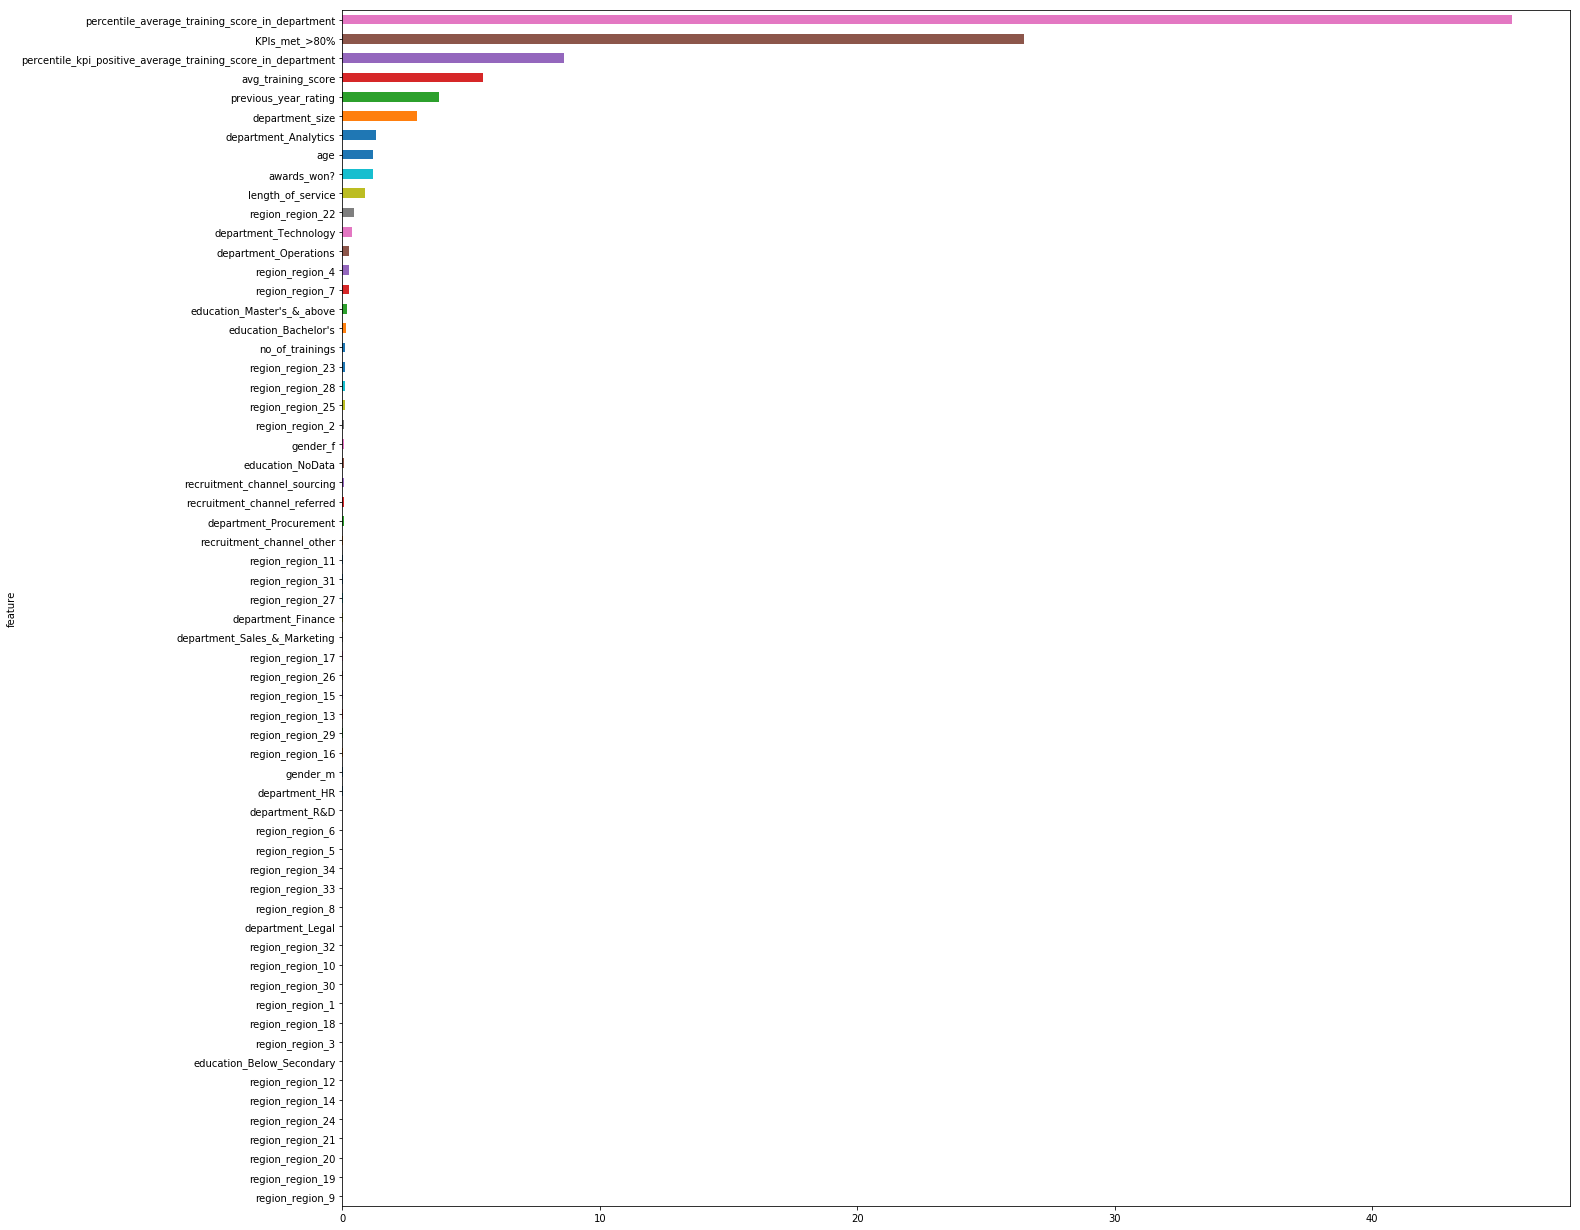

In [33]:
feature_importance.groupby("feature")["gain"].mean().sort_values().plot(kind = "barh", figsize = (22,22))